# Crime prediction San Fransisco

This application predicts the probability of crimes of multiple category taking place within a neighborhood at a given date. 

This application builds on crime incident data from the San Frasisco Police Department during 2003-2015, combined with data delineating neghborhoods and census tracts. 

As features, we currently employ historical features (crime history of a location), demographic features (e.g. income, age, gender ratio), and date-time features (e.g. season, weekday).

Output is a probability prediction of all included crime categories (currently 7), given a heighborhood and a date.

This application builds on the ideas by Rumi et al., EPJ Data Science (2018), https://doi.org/10.1140/epjds/s13688-018-0171-7.

## Imports, helper classes and functions

In [231]:
#For nicer presentation, turn off some warnings. For development, turn them on again.
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=DataConversionWarning) 
warnings.filterwarnings('ignore', category=FutureWarning)

#basics & tools
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point
import rtree
from scipy.stats import randint as sp_randint
from time import time

#sklearn & adjacent
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, confusion_matrix, make_scorer, classification_report

#plotting
import geoplot as gplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [169]:
#source: https://github.com/ageron/handson-ml
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    """Binarize Label in a One vs all fashion. This utility class would
    enable people to use this with categorical variables in pipelines. 
    Refer to LabelBinarizer for detailed info. 
    """ 
    def fit(self, X, y = None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X,y = None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [170]:
def obtain_and_plot_evaluation_figures(model, X, y, method, datatype, cv=3, verbose=100, title_prefix=None):
    if datatype == 'train':
        y_pred = cross_val_predict(model, X, y, cv=cv, method=method, verbose=verbose)
    elif datatype == 'test':
        y_pred = model.predict_proba(X)
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred[:,1])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5));
    ax1.plot(thresholds, precisions[:-1], "b--", label="Precision");
    ax1.plot(thresholds, recalls[:-1], "g-", label="Recall");
    ax1.set(xlabel="Thresholds");
    ax1.set_ylim([0,1]);
    ax1.legend();
    ax1.set_title(title_prefix + 'Precision & recall at thresholds');

    ax2.plot(precisions, recalls, label=None);
    ax2.set_ylim([0,1]);
    ax2.set_xlim([0,1]);
    ax2.set(xlabel="Precision", ylabel="Recall");
    ax2.set_title(title_prefix + 'Precision-recall curve');

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]

def get_standard_scores():
    scores = {'recall' : 'recall', 'precision' : 'precision', 
          'roc_auc' : 'roc_auc', 'avg_precision' : 'average_precision',
          'f1' : 'f1', 
          'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
          'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}
    return scores

def generate_results_df(grid_searcher, scores, generate_files=False):
    #keep all columns for future analyses
    result_df_full = pd.DataFrame(grid_searcher.cv_results_)
    #create a nimbler df
    result_df_compact = pd.DataFrame(index=result_df_full.index)
    for col in [col for col in result_df_full.columns if 'mean_test' in col]:
        #First, check to see if we have a mean_test_score column, whcih indicates only one unnamed metric (from BayesSearchCV)
        #If so, fill in name; else, handle multiple metrics. We don't have to break the loop, since mean_test_score implies only one 'mean_test'-column.
        if 'mean_test_score' in col and type(scores) is str:
            result_df_compact[scores] = result_df_full[[col, col.replace('mean_', 'std_')]].round(3).astype(str).apply(lambda x: ' +/- '.join(x), axis=1)
        else:
            #Confusion matrix must be handled separately
            if '_tp' not in col and '_tn' not in col and '_fn' not in col and '_fp' not in col:
                result_df_compact[col.replace('mean_test_','')] = result_df_full[[col, col.replace('mean_', 'std_')]].round(3).astype(str).apply(lambda x: ' +/- '.join(x), axis=1)
            else:
                #only do the confusion once
                if 'tp_fp_fn_tn' not in result_df_compact.columns:
                    for metric in ['tp','fp','fn','tn']:
                        #sum confusion matrix elements to match total number of samples
                        result_df_full[metric+'_sum'] = result_df_full[[column for column in result_df_full.columns if metric in column and 'split' in column]].sum(axis=1)
                    result_df_compact['tp_fp_fn_tn'] = result_df_full[['tp_sum', 'fp_sum', 'fn_sum', 'tn_sum']].astype(int).astype(str).apply(lambda x: '/'.join(x), axis=1)
    result_df_compact['time_fit_score'] = result_df_full[['mean_fit_time', 'mean_score_time']].round(3).astype(str).apply(lambda x: ' + '.join(x), axis=1)
    #add all parameters individually to the compact df
    param_cols=[col for col in result_df_full.columns if 'param_' in col]
    #transfer all parameter columns to compact df
    for col in param_cols:
        result_df_compact[col] = result_df_full[col].copy()
    #we usually want to save the results in a file
    if generate_files:
        estimator=str(grid_searcher.estimator).split('(')[0]+'_'
        #If we use a pipeline, list all estimators/samplers/tranformers in the file name
        if estimator=='Pipeline_':
            estimator=""
            for key, value in grid_searcher.estimator.named_steps.items():
                estimator+=str(value).split('(')[0]+'_'
        #TODO: set output dir of file
        opwd = './'
        ofile = 'Results_df_'+estimator+time.strftime("%Y%m%d_%H%M%S")+'.csv'
        result_df_compact.to_csv(opwd+ofile, sep=',')
        ofile = 'Full_results_df_'+estimator+'_'+time.strftime("%Y%m%d_%H%M%S")+'.csv'
        result_df_full.to_csv(opwd+ofile, sep=',')
    return result_df_full, result_df_compact

## Core data load and transform

### Load Crime data

In [239]:
#Source: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry
data_import = pd.read_csv('data/SF Crime Data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
#Only include relevant categories
crime_cats=['LARCENY/THEFT', 'ASSAULT', 'VEHICLE THEFT', 'VANDALISM', 'BURGLARY', 'ROBBERY', 'DRUG/NARCOTIC']
crime_data = data_import.loc[data_import['Category'].isin(crime_cats)].copy()
#Convert to datetime format
crime_data.loc[:,'Date'] = pd.to_datetime(crime_data['Date'])
crime_data.loc[:,'year'] = crime_data['Date'].dt.year
#Clean
crime_data = crime_data.rename(columns={'Category':'Crime_cat'})
crime_data = crime_data.drop(['IncidntNum', 'Address', 'Resolution', 'Location', 'PdId'], axis=1)
crime_data = crime_data.drop(crime_data.loc[crime_data['Y']>45].index)

In [240]:
#Convert X, Y to point geometry
geometry = [Point(xy) for xy in zip(crime_data.X, crime_data.Y)]
crs = {'init': 'epsg:4326', 'no_defs': True} #WGS84
crime_data = gpd.GeoDataFrame(crime_data, crs=crs, geometry=geometry)

In [241]:
crime_data.head()

,Crime_cat,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,year,geometry
1,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01,15:45,TENDERLOIN,-122.414406,37.784191,2015,POINT (-122.414406029855 37.7841907151119)
2,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01,15:45,TENDERLOIN,-122.414406,37.784191,2015,POINT (-122.414406029855 37.7841907151119)
4,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27,19:00,NORTHERN,-122.431119,37.800469,2015,POINT (-122.431118543788 37.8004687042875)
7,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Saturday,2015-01-31,21:00,BAYVIEW,-122.374019,37.729203,2015,POINT (-122.374019331833 37.729203356539)
8,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Saturday,2015-01-31,16:09,CENTRAL,-122.406568,37.787809,2015,POINT (-122.40656817787 37.7878092959561)


### Load census tracts data

In [242]:
#source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods-2010-census-tracts-assigned/bwbp-wk3r
#Some data are given per census tract, so necessary to include it although the spatial granularity of this approach is neighborhood.
CT_polg = gpd.read_file('data/Analysis Neighborhoods census tracts/Analysis Neighborhoods - 2010 census tracts assigned to neighborhoods/geo_export_cb4da69b-a53a-45a0-aa3a-4976974962d2.shp')
CT_polg.crs = {'init': 'epsg:4326', 'no_defs': True}

CT_polg = CT_polg.rename(columns={'tractce10':'CT', 'nhood':'NH', 'shape_area':'Area'})
CT_polg['CT'] = CT_polg['CT'].astype(float)/100
#NH_polg.plot(figsize=(6,6));

In [243]:
CT_polg.head()

,geoid,NH,Area,shape_len,CT,geometry
0,06075016400,Hayes Valley,3.326589e+06,7589.679396,164.0,POLYGON ((-122.4324669997095 37.77375700028448...
1,06075016100,Western Addition,3.970259e+06,8525.808755,161.0,POLYGON ((-122.4235409996432 37.77967400025458...
2,06075015900,Western Addition,3.179072e+06,8000.966619,159.0,POLYGON ((-122.4246870001921 37.78533500040309...
3,06075015500,Japantown,3.364565e+06,12144.016761,155.0,POLYGON ((-122.4246870001921 37.78533500040309...
4,06075015300,Pacific Heights,2.515363e+06,6918.268026,153.0,POLYGON ((-122.4349179998128 37.78587599994257...


### Load neighborhoods data

In [244]:
#source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h
#Given by grouped census tracts with similar demographic characteristics. More info at source.
NH_polg = gpd.read_file('data/Analysis Neighborhoods/geo_export_08432dc0-b4e4-4b62-8a75-f5512aeed55b.shp')
NH_polg.crs = {'init': 'epsg:4326', 'no_defs': True}
NH_polg = NH_polg.rename(columns={'nhood':'NH'})
NH_polg.head()
#NH_polg.plot(figsize=(6,6));

,NH,geometry
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,..."
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...
3,Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...
4,Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...


### Join neighborhoods to crime data

In [245]:
#Spatial join adding NH:s to crime data
crime_data = sjoin(crime_data, NH_polg, how="left")
crime_data.head()

,Crime_cat,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,year,geometry,index_right,NH
1,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01,15:45,TENDERLOIN,-122.414406,37.784191,2015,POINT (-122.414406029855 37.7841907151119),14.0,Tenderloin
2,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01,15:45,TENDERLOIN,-122.414406,37.784191,2015,POINT (-122.414406029855 37.7841907151119),14.0,Tenderloin
4,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27,19:00,NORTHERN,-122.431119,37.800469,2015,POINT (-122.431118543788 37.8004687042875),18.0,Marina
7,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Saturday,2015-01-31,21:00,BAYVIEW,-122.374019,37.729203,2015,POINT (-122.374019331833 37.729203356539),0.0,Bayview Hunters Point
8,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Saturday,2015-01-31,16:09,CENTRAL,-122.406568,37.787809,2015,POINT (-122.40656817787 37.7878092959561),5.0,Financial District/South Beach


### A look at the core data

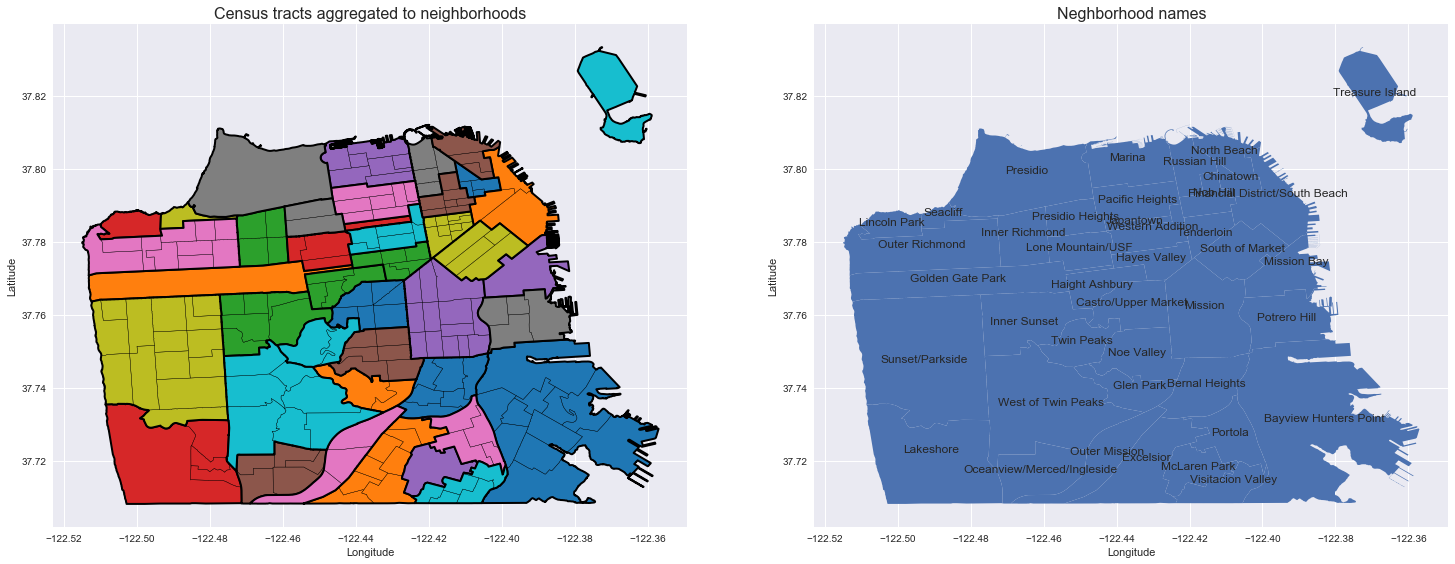

In [251]:
fig, ax = plt.subplots(1,2, figsize=(20,20))

ax[0].set_title('Census tracts aggregated to neighborhoods', fontsize=16)
ax[0].set(xlabel='Longitude', ylabel='Latitude')
NH_polg.plot(linewidth=2, edgecolor='black', column='NH', ax=ax[0]);
CT_polg.plot(ax=ax[0], linewidth=0.3, edgecolor='black', facecolor='None');

ax[1].set_title('Neghborhood names', fontsize=16)
ax[1].set(xlabel='Longitude', ylabel='Latitude')
NH_polg['coords'] = NH_polg['geometry'].apply(lambda x: x.representative_point().coords[:])
NH_polg['coords'] = [coords[0] for coords in NH_polg['coords']]
NH_polg.plot(ax=ax[1])
for idx, row in NH_polg.iterrows():
    plt.annotate(s=row['NH'], xy=row['coords'],
                 horizontalalignment='center')

In [252]:
#Crime category ratio in percent
c = crime_data.groupby('Crime_cat').size().sort_values(ascending=False)
#c = data_import.groupby('Category').size().sort_values(ascending=False)
round(c/len(data_import)*100, 2)

Crime_cat
LARCENY/THEFT    21.69
ASSAULT           8.79
VEHICLE THEFT     5.71
DRUG/NARCOTIC     5.40
VANDALISM         5.24
BURGLARY          4.13
ROBBERY           2.52
dtype: float64

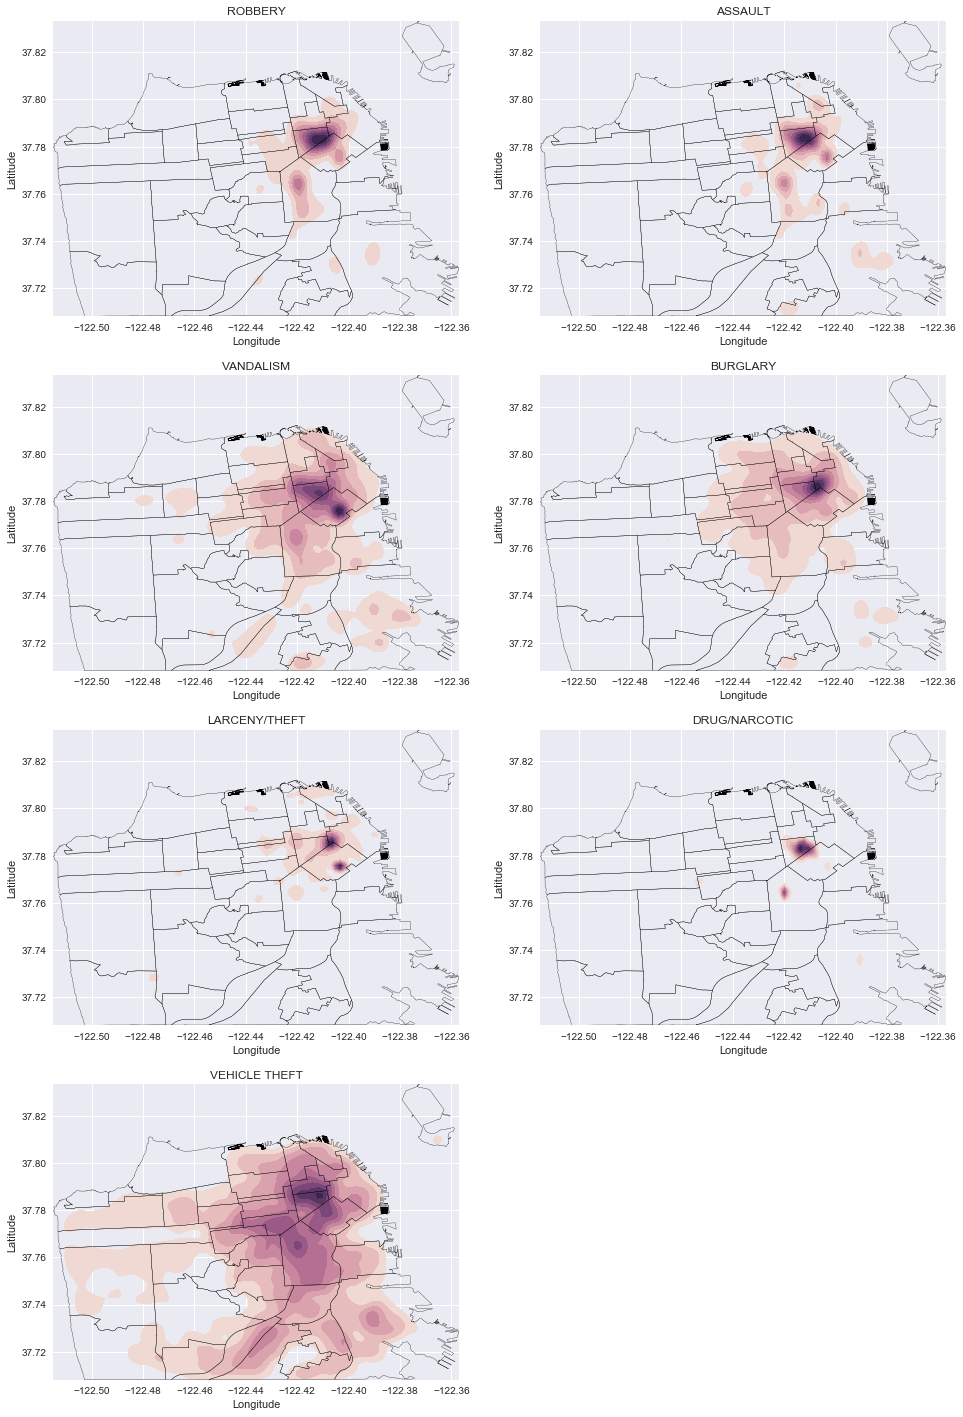

In [180]:
#x, y position in subplot. y could be set dynamically from ceiling(count(dimension members)/2), given x=2.
x=2; y=4
#All included crime categories
crime_cats = crime_data.drop('geometry', axis=1).drop_duplicates('Crime_cat')['Crime_cat'].tolist()
#Prep
fig, ax = plt.subplots(y,x, figsize=(16,25))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)    
plt_pos = [[i,j] for i in range(0,y) for j in range(0,x)]

#Plot
i=0
for crime in crime_cats:
    x,y = plt_pos[i]

    gplt.kdeplot(crime_data.query('Crime_cat == @crime'),
                     shade=True, shade_lowest=False
                     , cmap=cmap, ax=ax[x,y]);
    gplt.polyplot(NH_polg, ax=ax[x,y]);
    ax[x,y].set_title(crime_cats[i]);
    ax[x,y].set(xlabel='Longitude', ylabel='Latitude');
    
    i+=1

## Features data load and transform

### Median age

In [181]:
#source: https://factfinder.census.gov/bkmk/table/1.0/en/ACS/17_5YR/B01002/0500000US06075.14000
#Median age is given per census tract for a given year. Here, we use year 2017.
age = pd.read_csv('data/Median age/ACS_17_5YR_B01002/ACS_17_5YR_B01002_with_ann.csv', header=1)
age.head(3)

,Id,Id2,Geography,Estimate; Median age -- - Total:,Margin of Error; Median age -- - Total:,Estimate; Median age -- - Male,Margin of Error; Median age -- - Male,Estimate; Median age -- - Female,Margin of Error; Median age -- - Female
0,1400000US06075010100,6075010100,"Census Tract 101, San Francisco County, Califo...",40.2,4.6,34.7,3.3,44.9,3.3
1,1400000US06075010200,6075010200,"Census Tract 102, San Francisco County, Califo...",39.1,5.5,39.3,7.7,37.9,7.6
2,1400000US06075010300,6075010300,"Census Tract 103, San Francisco County, Califo...",39.5,5.3,37.1,3.6,42.5,3.0


In [182]:
age = age[['Geography','Estimate; Median age -- - Total:']]
age = age.rename(columns={'Geography':'CT', 'Estimate; Median age -- - Total:':'median_age'})
age['median_age'] = age['median_age'].replace('-',np.nan).astype(float)
age['CT'] = age['CT'].str.extract('(\d+(\.\d+)?)')[0].astype(float)

In [183]:
age.head()

,CT,median_age
0,101.0,40.2
1,102.0,39.1
2,103.0,39.5
3,104.0,40.1
4,105.0,45.7


### Median income

In [184]:
#source: https://factfinder.census.gov/bkmk/table/1.0/en/ACS/17_5YR/S1903/0500000US06075.14000
#Median income, per census tract, 2017, inflation-adjusted dollars
income = pd.read_csv('data/Median income/ACS_17_5YR_S1903/ACS_17_5YR_S1903_with_ann.csv', header=1)
income.head(3)

,Id,Id2,Geography,Number; Estimate; Households,Number; Margin of Error; Households,Percent Distribution; Estimate; Households,Percent Distribution; Margin of Error; Households,Median income (dollars); Estimate; Households,Median income (dollars); Margin of Error; Households,Number; Estimate; Households - One race-- - White,...,Percent Distribution; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone,Percent Distribution; Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone,Median income (dollars); Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone,Median income (dollars); Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone,Number; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone,Number; Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone,Percent Distribution; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone,Percent Distribution; Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone,Median income (dollars); Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone,Median income (dollars); Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone
0,1400000US06075010100,6075010100,"Census Tract 101, San Francisco County, Califo...",2035,122,2035,122,81509,19512,1157,...,33.0,10.6,94476,19473,201,88,16.8,7.4,216516,31396
1,1400000US06075010200,6075010200,"Census Tract 102, San Francisco County, Califo...",2504,213,2504,213,125238,22090,2180,...,30.2,10.1,78207,54619,284,133,16.5,8.2,191136,80881
2,1400000US06075010300,6075010300,"Census Tract 103, San Francisco County, Califo...",2022,162,2022,162,118210,22286,1436,...,30.9,12.7,100067,62518,242,120,22.0,10.6,155652,30587


In [185]:
income = income[['Geography', 'Median income (dollars); Estimate; Households']]
income = income.rename(columns={'Geography':'CT', 'Median income (dollars); Estimate; Households':'median_income'})
income['median_income'] = income['median_income'].replace('-',np.nan).astype(float)
income['CT'] = income['CT'].str.extract('(\d+(\.\d+)?)')[0].astype(float)

In [186]:
income.head()

,CT,median_income
0,101.0,81509.0
1,102.0,125238.0
2,103.0,118210.0
3,104.0,106979.0
4,105.0,108063.0


### Evictions

In [187]:
#source: https://data.sfgov.org/Housing-and-Buildings/Count-of-Eviction-Notices-By-Analysis-Neighborhood/esx7-7kzy
#Count of eviction notices per year and per neighborhood (boundaries consistent with here employed neghborhood data)
evictions = pd.read_csv('data/Evictions/Count_of_Eviction_Notices_By_Analysis_Neighborhood_and_Year.csv')
evictions.head()

,Neighborhoods - Analysis Boundaries,File Year,Count of Eviction Notices
0,Presidio Heights,01/01/2003 12:00:00 AM,17
1,Castro/Upper Market,01/01/2001 12:00:00 AM,116
2,Hayes Valley,01/01/2002 12:00:00 AM,49
3,Hayes Valley,01/01/1998 12:00:00 AM,177
4,Bernal Heights,01/01/2005 12:00:00 AM,47


In [188]:
evictions['year'] = pd.to_datetime(evictions['File Year']).dt.year
evictions = evictions.rename(columns={'Neighborhoods - Analysis Boundaries':'NH', 'Count of Eviction Notices':'evictions'})
evictions = evictions.drop('File Year', axis=1)

In [189]:
evictions.head()

,NH,evictions,year
0,Presidio Heights,17,2003
1,Castro/Upper Market,116,2001
2,Hayes Valley,49,2002
3,Hayes Valley,177,1998
4,Bernal Heights,47,2005


### Population count, sex and age ratio

In [190]:
#source: https://factfinder.census.gov/bkmk/table/1.0/en/ACS/17_5YR/DP05/0500000US06075.14000
#ACS 2017 demographic and housing estimates. Includes distributions of age, sex, race, etc, per census tract.
pop = pd.read_csv('data/Population count/ACS_17_5YR_DP05/ACS_17_5YR_DP05_with_ann.csv', header=1)
pop.head(3)

,Id,Id2,Geography,Estimate; SEX AND AGE - Total population,Margin of Error; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population,Percent Margin of Error; SEX AND AGE - Total population,Estimate; SEX AND AGE - Total population - Male,Margin of Error; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Male,...,"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female","Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female","Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female"
0,1400000US06075010100,6075010100,"Census Tract 101, San Francisco County, Califo...",3967,251,3967,(X),1914,263,48.2,...,2953,(X),1462,252,49.5,6.8,1491,221,50.5,6.8
1,1400000US06075010200,6075010200,"Census Tract 102, San Francisco County, Califo...",4363,374,4363,(X),2137,289,49.0,...,3766,(X),1841,265,48.9,5.6,1925,251,51.1,5.6
2,1400000US06075010300,6075010300,"Census Tract 103, San Francisco County, Califo...",4377,397,4377,(X),2339,314,53.4,...,3516,(X),1949,317,55.4,6.0,1567,235,44.6,6.0


In [191]:
pop = pop[['Geography', 'Estimate; SEX AND AGE - Total population', 'Percent; SEX AND AGE - Total population - Male', 'Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population']]
pop = pop.rename(columns={'Geography':'CT', 'Estimate; SEX AND AGE - Total population':'Pop_cnt', 'Percent; SEX AND AGE - Total population - Male':'Male_pop_ratio', 'Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population':'Age18Plus_cnt'})
pop['CT'] = pop['CT'].str.extract('(\d+(\.\d+)?)')[0].astype(float)
pop['Male_pop_ratio'] = pop['Male_pop_ratio'].replace('-',np.nan).astype(float)

In [192]:
pop.head()

,CT,Pop_cnt,Male_pop_ratio,Age18Plus_cnt
0,101.0,3967,48.2,2953
1,102.0,4363,49.0,3766
2,103.0,4377,53.4,3516
3,104.0,4645,50.9,3720
4,105.0,2691,52.2,1983


## Construct feature matrix

### Time grid crime data

In [193]:
#To obtain labeled data, also with crime event=0, we grid the data and count number of crime per date, 
#neighborhood and crime category.The exact formulation here mirrors the prediction scope and resolution 
#of these three factors, here chosen somewhat arbitrarily, mostly with practical considerations.
crime_data_grd = crime_data.groupby(['NH', 'Date', 'Crime_cat']).size()

#Fill along all dimensions -- missing data means no crime incidents, some stacking gymnastics required
crime_data_grd = crime_data_grd.unstack(['NH', 'Crime_cat']).asfreq('D').fillna(0).stack(['NH', 'Crime_cat'])
crime_data_grd = pd.DataFrame(crime_data_grd).rename(columns={0:'Crime_count'})

In [194]:
crime_data_grd.head(20)

Crime_count
Date       NH                    Crime_cat                 
2003-01-01 Bayview Hunters Point ASSAULT                9.0
                                 BURGLARY               1.0
                                 DRUG/NARCOTIC          1.0
                                 LARCENY/THEFT          6.0
                                 ROBBERY                1.0
                                 VANDALISM              4.0
                                 VEHICLE THEFT          3.0
           Bernal Heights        ASSAULT                1.0
                                 BURGLARY               2.0
                                 DRUG/NARCOTIC          0.0
                                 LARCENY/THEFT          1.0
                                 ROBBERY                0.0
                                 VANDALISM              1.0
                                 VEHICLE THEFT          3.0
           Castro/Upper Market   ASSAULT                1.0
                                 BURGLARY               1.0
                                 DRUG/NARCOTIC          0.0
                                 LARCENY/THEFT          1.0
                                 ROBBERY                0.0
                                 VANDALISM              0.0

### Aggregate and merge features

#### Features to first aggregate to NH granularity

In [195]:
CT_polg = CT_polg.merge(age, how='left', on='CT')
CT_polg = CT_polg.merge(income, how='left', on='CT')
CT_polg = CT_polg.merge(pop, how='left', on='CT')

In [196]:
CT_polg.head()

,geoid,NH,Area,shape_len,CT,geometry,median_age,median_income,Pop_cnt,Male_pop_ratio,Age18Plus_cnt
0,06075016400,Hayes Valley,3.326589e+06,7589.679396,164.0,POLYGON ((-122.4324669997095 37.77375700028448...,35.2,119321.0,3915,48.5,3468
1,06075016100,Western Addition,3.970259e+06,8525.808755,161.0,POLYGON ((-122.4235409996432 37.77967400025458...,38.5,24041.0,5562,44.9,3871
2,06075015900,Western Addition,3.179072e+06,8000.966619,159.0,POLYGON ((-122.4246870001921 37.78533500040309...,35.4,62731.0,4432,52.6,2978
3,06075015500,Japantown,3.364565e+06,12144.016761,155.0,POLYGON ((-122.4246870001921 37.78533500040309...,54.9,65536.0,3740,45.0,3149
4,06075015300,Pacific Heights,2.515363e+06,6918.268026,153.0,POLYGON ((-122.4349179998128 37.78587599994257...,35.7,120833.0,2210,45.5,1773


In [197]:
#Weighted average lambda function
wm = lambda x: np.average(x, weights=CT_polg.loc[x.index, 'Pop_cnt'])
#Set aggregating functions per column
f = {'Area': ['sum']
     , 'Pop_cnt': ['sum']
     , 'median_age': [wm]
     , 'median_income': [wm]
     , 'Male_pop_ratio': [wm]
     , 'Age18Plus_cnt': ['sum']
    }
temp = CT_polg.groupby('NH').agg(f)
#Clean
temp.columns = temp.columns.droplevel(1)

In [198]:
#Join aggregated features to NH_data
NH_polg = NH_polg.merge(temp, on='NH', how='left')

In [199]:
NH_polg.head()

,NH,geometry,Area,Pop_cnt,median_age,median_income,Male_pop_ratio,Age18Plus_cnt
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...,1.442175e+08,37694,36.460272,58568.425187,48.540487,23334
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,...",3.005083e+07,26705,39.087744,123342.065269,52.268957,18611
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...,2.389681e+07,21875,40.622757,137839.080274,61.714359,18242
3,Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...,6.262576e+06,14539,50.529019,25671.903226,48.683135,9328
4,Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...,3.881160e+07,40414,42.281957,74677.059014,50.964589,26927


#### Features of NH granularity

In [200]:
evictions.head()

,NH,evictions,year
0,Presidio Heights,17,2003
1,Castro/Upper Market,116,2001
2,Hayes Valley,49,2002
3,Hayes Valley,177,1998
4,Bernal Heights,47,2005


### Join features with gridded crime data

In [201]:
crime_data_grd.head()

Crime_count
Date       NH                    Crime_cat                 
2003-01-01 Bayview Hunters Point ASSAULT                9.0
                                 BURGLARY               1.0
                                 DRUG/NARCOTIC          1.0
                                 LARCENY/THEFT          6.0
                                 ROBBERY                1.0

In [202]:
#Need to reset_index to not dump non-join columns
crime_data_grd = crime_data_grd.reset_index()
#Features per NH
crime_data_grd = crime_data_grd.merge(NH_polg, on='NH', how='left')
#Feature per year and NH
crime_data_grd['year'] = crime_data_grd['Date'].dt.year
crime_data_grd = crime_data_grd.merge(evictions, on=['NH', 'year'], how='left')

In [203]:
crime_data_grd.head()

,Date,NH,Crime_cat,Crime_count,geometry,Area,Pop_cnt,median_age,median_income,Male_pop_ratio,Age18Plus_cnt,year,evictions
0,2003-01-01,Bayview Hunters Point,ASSAULT,9.0,POLYGON ((-122.3815777424142 37.75307043091241...,1.442175e+08,37694,36.460272,58568.425187,48.540487,23334,2003,39.0
1,2003-01-01,Bayview Hunters Point,BURGLARY,1.0,POLYGON ((-122.3815777424142 37.75307043091241...,1.442175e+08,37694,36.460272,58568.425187,48.540487,23334,2003,39.0
2,2003-01-01,Bayview Hunters Point,DRUG/NARCOTIC,1.0,POLYGON ((-122.3815777424142 37.75307043091241...,1.442175e+08,37694,36.460272,58568.425187,48.540487,23334,2003,39.0
3,2003-01-01,Bayview Hunters Point,LARCENY/THEFT,6.0,POLYGON ((-122.3815777424142 37.75307043091241...,1.442175e+08,37694,36.460272,58568.425187,48.540487,23334,2003,39.0
4,2003-01-01,Bayview Hunters Point,ROBBERY,1.0,POLYGON ((-122.3815777424142 37.75307043091241...,1.442175e+08,37694,36.460272,58568.425187,48.540487,23334,2003,39.0


### Drop/fill nan:s

In [204]:
crime_data_grd.isna().sum()

Date                   0
NH                     0
Crime_cat              0
Crime_count            0
geometry               0
Area                   0
Pop_cnt                0
median_age             0
median_income          0
Male_pop_ratio         0
Age18Plus_cnt          0
year                   0
evictions         171969
dtype: int64

In [205]:
#Fill evictions NA -- no record means 0 evictions
crime_data_grd['evictions'] = crime_data_grd['evictions'].fillna(value=0)

In [206]:
crime_data_grd.isna().sum()

Date              0
NH                0
Crime_cat         0
Crime_count       0
geometry          0
Area              0
Pop_cnt           0
median_age        0
median_income     0
Male_pop_ratio    0
Age18Plus_cnt     0
year              0
evictions         0
dtype: int64

### Engineered features

Let's reformulate a few features a bit and derive some features from date

In [207]:
#Evictions per 1000 capita
crime_data_grd['evictions_PkC'] = crime_data_grd['evictions']/crime_data_grd['Pop_cnt']*1000

In [208]:
#Weekday attributes
crime_data_grd['weekday_num'] = crime_data_grd['Date'].dt.weekday
crime_data_grd['weekend'] = np.where(crime_data_grd['weekday_num'] >= 4, 1, 0)

#Proxy for season: Q-1M
crime_data_grd['Season'] = (crime_data_grd['Date'] - pd.DateOffset(months=1)).dt.quarter

crime_data_grd['Age18Plus_ratio'] = crime_data_grd['Age18Plus_cnt']/crime_data_grd['Pop_cnt']*100

Construct $\alpha$-days crime density features, following Rumi et al. (2018), sect. 4.1.1.m with $\alpha=7$ and $\alpha=30$:
$$DA_i(NH, date)=\frac{\sum^d_{j=d-\alpha} Cr_j(NH)}{A(NH)},$$ and
$$DP_i(NH, date)=\frac{\sum^d_{j=d-\alpha} Cr_j(NH)}{P(NH)},$$
where $Cr_j(NH)$ is the number of crime events occurres at day $j$ in neighborhood NH during the last $\alpha$ days, and $A(NH)$ and $P(NH)$ are the neghorhood area and population count, respectively.

In [209]:
#alpha-days crime event density
alpha=7
aslice=pd.DataFrame()
for cat in crime_data_grd['Crime_cat'].unique():
    for nh in crime_data_grd['NH'].unique():
        #Slice data per nh-crime_cat
        dslice = crime_data_grd.query('Crime_cat == @cat and NH == @nh')[['NH','Crime_cat','Date','Crime_count']]
        #Rolling sum 
        rollslice = dslice[['Date','Crime_count']].rolling(alpha, center=False, on='Date').sum().fillna(method='bfill')
        rollslice = rollslice.rename(columns={'Crime_count':'Rolling_sum'})
        #merge
        dslice = dslice.merge(rollslice, on='Date', how='left').drop('Crime_count', axis=1)
        aslice = pd.concat([aslice, dslice],ignore_index=True)
#merge with main table
crime_data_grd = crime_data_grd.merge(aslice, on=['Date', 'NH', 'Crime_cat'], how='left')
colnames=['alpha_crime_dens_pop_'+str(alpha),'alpha_crime_dens_area_'+str(alpha)]
#normalize
crime_data_grd[colnames[0]] = crime_data_grd['Rolling_sum']/crime_data_grd['Pop_cnt']
crime_data_grd[colnames[1]] = crime_data_grd['Rolling_sum']/crime_data_grd['Area']
crime_data_grd = crime_data_grd.drop('Rolling_sum', axis=1)

In [210]:
#alpha-days crime event density
alpha=30
aslice=pd.DataFrame()
for cat in crime_data_grd['Crime_cat'].unique():
    for nh in crime_data_grd['NH'].unique():
        #Slice data per nh-crime_cat
        dslice = crime_data_grd.query('Crime_cat == @cat and NH == @nh')[['NH','Crime_cat','Date','Crime_count']]
        #Rolling sum 
        rollslice = dslice[['Date','Crime_count']].rolling(alpha, center=False, on='Date').sum().fillna(method='bfill')
        rollslice = rollslice.rename(columns={'Crime_count':'Rolling_sum'})
        #merge
        dslice = dslice.merge(rollslice, on='Date', how='left').drop('Crime_count', axis=1)
        aslice = pd.concat([aslice, dslice],ignore_index=True)
#merge with main table
crime_data_grd = crime_data_grd.merge(aslice, on=['Date', 'NH', 'Crime_cat'], how='left')
colnames=['alpha_crime_dens_pop_'+str(alpha),'alpha_crime_dens_area_'+str(alpha)]
#normalize
crime_data_grd[colnames[0]] = crime_data_grd['Rolling_sum']/crime_data_grd['Pop_cnt']
crime_data_grd[colnames[1]] = crime_data_grd['Rolling_sum']/crime_data_grd['Area']
crime_data_grd = crime_data_grd.drop('Rolling_sum', axis=1)

## Maps of the features

In [211]:
#Adding this here since one cannot drop_duplicate with a Polygon geometry column present
NH_polg['Age18Plus_ratio'] = NH_polg['Age18Plus_cnt']/NH_polg['Pop_cnt']*100

In [212]:
#silly gymnastics to plot evictions and crime_count due to shortcomings of groupby and drop_duplicates with regard to polygon geometry
plot_temp_evictions = gpd.GeoDataFrame(crime_data_grd[['NH', 'evictions','year']].drop_duplicates().groupby(['NH']).sum()['evictions']).merge(NH_polg, on='NH', how='left')
plot_temp_evictions['evictions_norm'] = plot_temp_evictions['evictions'] / plot_temp_evictions['Pop_cnt']
plot_temp_crime = gpd.GeoDataFrame(crime_data_grd.groupby(['NH']).sum()['Crime_count']).merge(NH_polg, on='NH', how='left')
plot_temp_crime['Crime_count_norm'] = plot_temp_crime['Crime_count'] / plot_temp_crime['Pop_cnt']

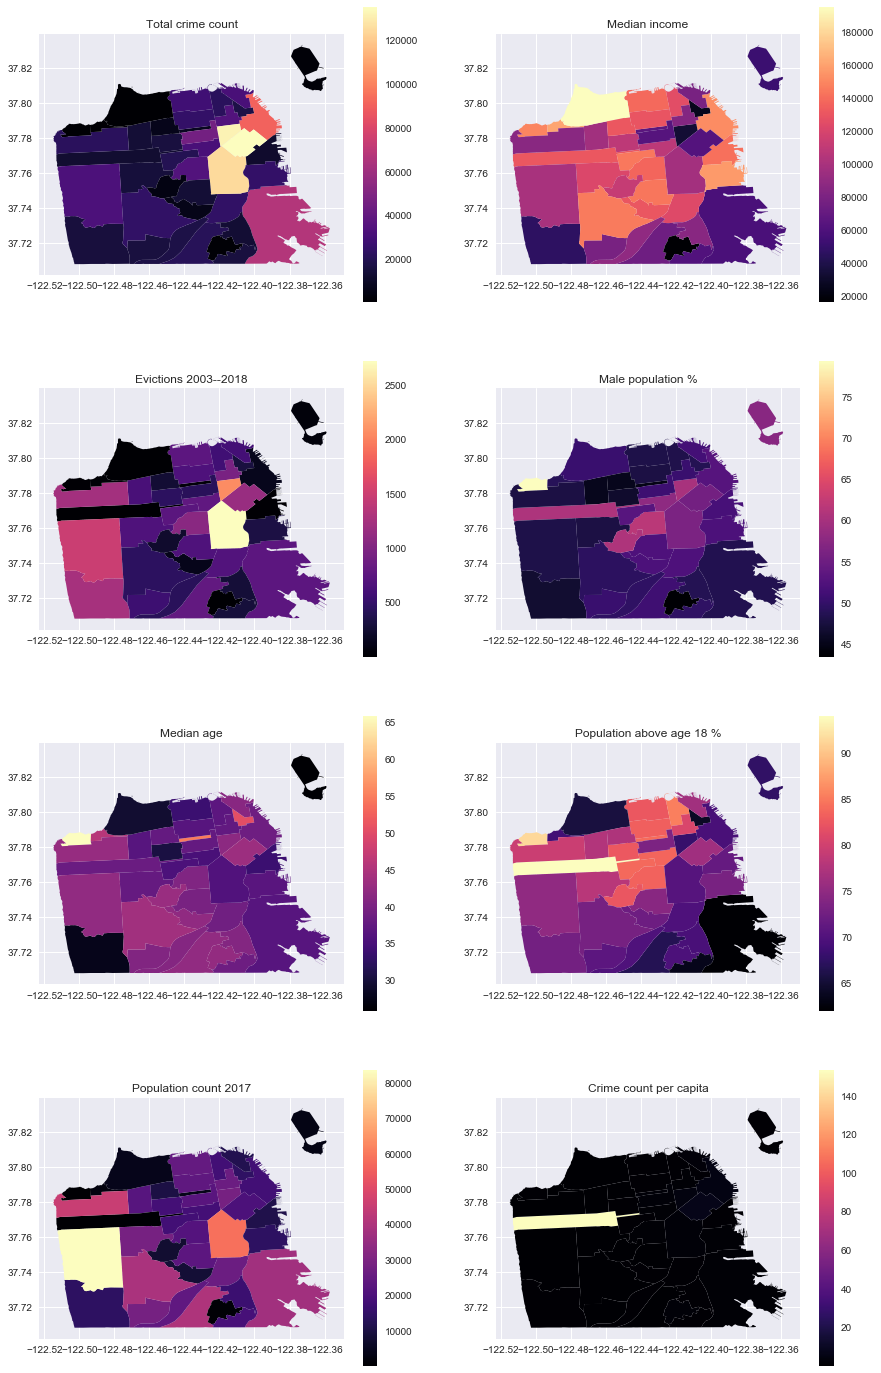

In [213]:
#One could add normalized crime count and evictions if desired
cmap = 'magma'
fig, ax = plt.subplots(4,2, figsize=(15,25));
ax[0,0].set_title("Total crime count")
plot_temp_crime.plot(ax=ax[0,0], column='Crime_count', cmap=cmap, legend=True);
ax[0,1].set_title("Median income")
NH_polg.plot(ax=ax[0,1], column='median_income', cmap=cmap, legend=True);
ax[1,0].set_title('Evictions 2003--2018')
plot_temp_evictions.plot(ax=ax[1,0], column='evictions', cmap=cmap, legend=True);
ax[1,1].set_title("Male population %")
NH_polg.plot(ax=ax[1,1], column='Male_pop_ratio', cmap=cmap, legend=True);
ax[2,0].set_title("Median age")
NH_polg.plot(ax=ax[2,0], column='median_age', cmap=cmap, legend=True);
ax[2,1].set_title("Population above age 18 %")
NH_polg.plot(ax=ax[2,1], column='Age18Plus_ratio', cmap=cmap, legend=True);
ax[3,0].set_title("Population count 2017")
NH_polg.plot(ax=ax[3,0], column='Pop_cnt', cmap=cmap, legend=True);
ax[3,1].set_title("Crime count per capita")
plot_temp_crime.plot(ax=ax[3,1], column='Crime_count_norm', cmap=cmap, legend=True);

## Correlation between features

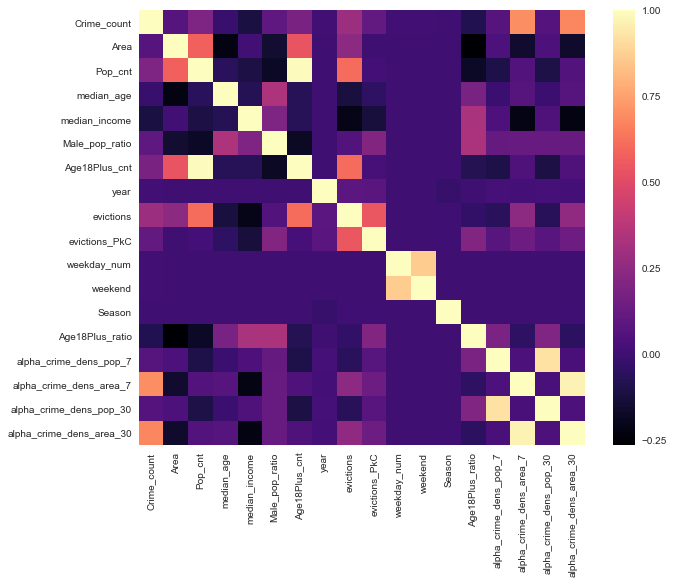

In [214]:
corr = crime_data_grd.corr()
fig, ax = plt.subplots(figsize=(10,8));
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=cmap,
            ax=ax);

## Train-dev-test split

Before we train/test split the data, let's take a look at class balance. Looking at crime_count in the figures below, it would make sense to both treat the problem as a regression problem and a classification problem. We've chosen to proceed with classification, but have prepared label dataframes for regression as well (i.e., y_train_reg and y_test_reg).

A comment on the train/test split: We follow Rumi et al. (2018) and split in time, where test data is the last 20-ish% of the data. On the one hand, this ensures that we won't use future information from the perspective of a predicted date, but on the other hand, we might bias the test data and ignore trends. 

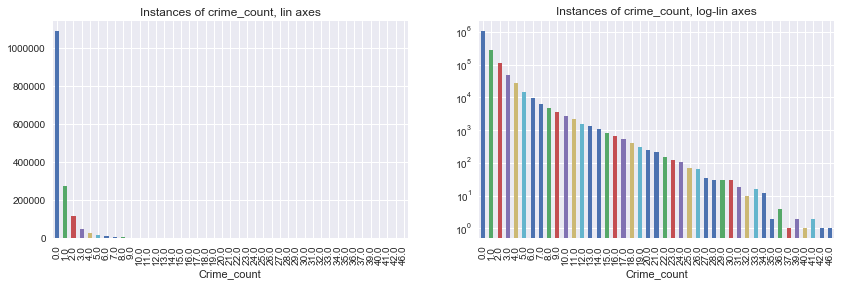

In [215]:
#Instances of crime_count per date, neighborhood, and crime category
cc = crime_data_grd.groupby('Crime_count').size()
fig, axes = plt.subplots(1, 2, figsize=(14, 4));
cc.plot.bar(logy=False, ax=axes[0], title='Instances of crime_count, lin axes');
cc.plot.bar(logy=True, ax=axes[1], title='Instances of crime_count, log-lin axes');

In [216]:
#For easier handling of predictions downstream
crime_data_grd = crime_data_grd.reindex(sorted(crime_data_grd.columns), axis=1)

In [217]:
X_train = crime_data_grd.query('Date < "2015-01-01"')
X_test = crime_data_grd.query('Date >= "2016-01-01"')

In [218]:
#labels for regression
y_train_reg = X_train['Crime_count']
y_test_reg = X_test['Crime_count']

#labels for classifier
y_train_clf = X_train['Crime_count'].clip(upper=1).astype(int)
y_test_clf = X_test['Crime_count'].clip(upper=1).astype(int)

In [219]:
#Clean
X_train = X_train.drop(['Crime_count','Age18Plus_cnt', 'evictions','Date','NH','geometry','year'], axis=1)
X_test = X_test.drop(['Crime_count','Age18Plus_cnt', 'evictions','Date','NH','geometry','year'], axis=1)

In [220]:
#Check split ratios
time_split = int(len(X_train)/(len(crime_data_grd))*100)
event_split = int(y_train_clf.sum()/(y_train_clf.sum()+y_test_clf.sum())*100)
print("Train/test split in time: {}/{}".format(time_split, 100-time_split))
print("Train/test split in events: {}/{}".format(event_split, 100-event_split))

Train/test split in time: 78/22
Train/test split in events: 83/17


## Model preprocessing pipeline

In [221]:
X_train.head()

,Age18Plus_ratio,Area,Crime_cat,Male_pop_ratio,Pop_cnt,Season,alpha_crime_dens_area_30,alpha_crime_dens_area_7,alpha_crime_dens_pop_30,alpha_crime_dens_pop_7,evictions_PkC,median_age,median_income,weekday_num,weekend
0,61.903751,1.442175e+08,ASSAULT,48.540487,37694,4,8.736801e-07,3.189626e-07,0.003343,0.001220,1.034647,36.460272,58568.425187,2,0
1,61.903751,1.442175e+08,BURGLARY,48.540487,37694,4,3.536324e-07,7.627366e-08,0.001353,0.000292,1.034647,36.460272,58568.425187,2,0
2,61.903751,1.442175e+08,DRUG/NARCOTIC,48.540487,37694,4,4.437740e-07,9.014160e-08,0.001698,0.000345,1.034647,36.460272,58568.425187,2,0
3,61.903751,1.442175e+08,LARCENY/THEFT,48.540487,37694,4,5.755194e-07,1.525473e-07,0.002202,0.000584,1.034647,36.460272,58568.425187,2,0
4,61.903751,1.442175e+08,ROBBERY,48.540487,37694,4,1.594813e-07,5.547175e-08,0.000610,0.000212,1.034647,36.460272,58568.425187,2,0


In [222]:
#Numerical features. Using a StandardScaler to be insensitive to any outliers.
num_attributes = X_train.select_dtypes(exclude=[object]).columns
num_mapper = DataFrameMapper(gen_features(
    columns=[[f] for f in num_attributes],
    classes=[
            StandardScaler
            ]
))

#Categorical features. One-hot encode (binarize) the features.
cat_attributes = X_train.select_dtypes(include=[object]).columns
cat_mapper = DataFrameMapper(gen_features(
    columns=[[f] for f in cat_attributes],
    classes=[LabelBinarizerPipelineFriendly]
))

#Union
full_pipeline = FeatureUnion(transformer_list=[
    ('num_mapper', num_mapper),
    ('cat_mapper', cat_mapper),
])

X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.transform(X_test)
print(num_attributes)
print(cat_attributes)
print(np.shape(X_train_prep))
print(X_train_prep[1])

Index(['Age18Plus_ratio', 'Area', 'Male_pop_ratio', 'Pop_cnt', 'Season',
       'alpha_crime_dens_area_30', 'alpha_crime_dens_area_7',
       'alpha_crime_dens_pop_30', 'alpha_crime_dens_pop_7', 'evictions_PkC',
       'median_age', 'median_income', 'weekday_num', 'weekend'],
      dtype='object')
Index(['Crime_cat'], dtype='object')
(1253538, 21)
[-1.77898725  3.8673165  -0.53680543  1.03272872  1.33563633 -0.26747561
 -0.27002509 -0.08097911 -0.07667074 -0.33260344 -0.462059   -1.09398898
 -0.4999287  -0.86585253  0.          1.          0.          0.
  0.          0.          0.        ]


## Model training

### Hyperparameter grid search

Going for a random forest model (again, arbitrarily), searching a few parameters we've found to usually make a difference. Random search is almost always better than than an exhaustive seach. For larger seaches, with either more parameters or a non-convex error function, one could use for example BayesSearchCV (https://scikit-optimize.github.io/#skopt.BayesSearchCV).

In [ ]:
param_grid = {
    'max_depth': sp_randint(5, 80),
    'n_estimators' : sp_randint(1, 200),
    'min_samples_leaf' : sp_randint(1, 400),
    'random_state' : [42],
    'max_features' : ['auto'],
    'class_weight' : ['balanced', None]
    }

scores = get_standard_scores()

n_iter = 40; cv=3
rfc = RandomForestClassifier()
rnd_search = RandomizedSearchCV(rfc, param_grid, n_iter=n_iter, cv=cv, scoring=scores, n_jobs=-1, refit=False, return_train_score=False, verbose=5)
rnd_search.fit(X_train_prep, y_train_clf)

_, gs_df = generate_results_df(rnd_search, scores)

In [66]:
gs_df.sort_values(by='avg_precision', ascending=False)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] class_weight=balanced, max_depth=17, max_features=auto, min_samples_leaf=37, n_estimators=15, random_state=42 
[CV] class_weight=balanced, max_depth=17, max_features=auto, min_samples_leaf=37, n_estimators=15, random_state=42 
[CV] class_weight=balanced, max_depth=17, max_features=auto, min_samples_leaf=37, n_estimators=15, random_state=42 
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=386, n_estimators=29, random_state=42 
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=386, n_estimators=29, random_state=42 
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=386, n_estimators=29, random_state=42 
[CV] class_weight=balanced, max_depth=62, max_features=auto, min_samples_leaf=24, n_estimators=30, random_state=42 
[CV] class_weight=balanced, max_depth=62, max_features=auto, min_samples_leaf=24, n_estimators=30, random_state=42 
[CV]  class_weight=

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min


[CV]  class_weight=balanced, max_depth=17, max_features=auto, min_samples_leaf=37, n_estimators=15, random_state=42, recall=0.8118099252047964, precision=0.6185148542838568, roc_auc=0.8797991634813611, avg_precision=0.7847837681059627, f1=0.7021013755683405, tp=109406, tn=215598, fp=67479, fn=25362, total= 1.3min
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=294, n_estimators=77, random_state=42 
[CV]  class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=386, n_estimators=29, random_state=42, recall=0.6551506652123262, precision=0.692322771361138, roc_auc=0.8708580030121369, avg_precision=0.7676218667086322, f1=0.6732239937171657, tp=88294, tn=243839, fp=39239, fn=46475, total= 2.2min
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=294, n_estimators=77, random_state=42 
[CV]  class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=386, n_estimators=29, random_state=42, recall=0.572917903359848, precision

[CV] class_weight=None, max_depth=23, max_features=auto, min_samples_leaf=212, n_estimators=197, random_state=42 
[CV]  class_weight=None, max_depth=52, max_features=auto, min_samples_leaf=140, n_estimators=98, random_state=42, recall=0.6580148253678516, precision=0.6915806220170322, roc_auc=0.8708582727228189, avg_precision=0.7674736888083536, f1=0.674380316125279, tp=88680, tn=243530, fp=39548, fn=46089, total= 8.1min
[CV] class_weight=None, max_depth=12, max_features=auto, min_samples_leaf=351, n_estimators=106, random_state=42 
[CV]  class_weight=None, max_depth=52, max_features=auto, min_samples_leaf=140, n_estimators=98, random_state=42, recall=0.5728733824053188, precision=0.7493230324265041, roc_auc=0.8749781237443701, avg_precision=0.7762297247560429, f1=0.6493244351369423, tp=77205, tn=257250, fp=25828, fn=57563, total= 8.2min
[CV] class_weight=None, max_depth=12, max_features=auto, min_samples_leaf=351, n_estimators=106, random_state=42 
[CV]  class_weight=None, max_depth=79

[CV]  class_weight=None, max_depth=35, max_features=auto, min_samples_leaf=185, n_estimators=56, random_state=42, recall=0.6571169927802388, precision=0.6924297867016951, roc_auc=0.8708303988400921, avg_precision=0.7674320887821282, f1=0.6743113852245256, tp=88559, tn=243741, fp=39337, fn=46210, total= 4.7min
[CV] class_weight=None, max_depth=72, max_features=auto, min_samples_leaf=60, n_estimators=128, random_state=42 
[CV]  class_weight=None, max_depth=35, max_features=auto, min_samples_leaf=185, n_estimators=56, random_state=42, recall=0.5710331829514425, precision=0.7506388872632216, roc_auc=0.8749760009709524, avg_precision=0.776217876638709, f1=0.6486324750305533, tp=76957, tn=257513, fp=25565, fn=57811, total= 4.7min
[CV] class_weight=None, max_depth=72, max_features=auto, min_samples_leaf=60, n_estimators=128, random_state=42 
[CV]  class_weight=None, max_depth=35, max_features=auto, min_samples_leaf=185, n_estimators=56, random_state=42, recall=0.5982280660097352, precision=0.

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 48.4min


[CV]  class_weight=balanced, max_depth=73, max_features=auto, min_samples_leaf=385, n_estimators=23, random_state=42, recall=0.8200982429063279, precision=0.6129338169234353, roc_auc=0.8799449657397883, avg_precision=0.7847694025263638, f1=0.7015418012859982, tp=110523, tn=213282, fp=69795, fn=24245, total= 1.9min
[CV] class_weight=balanced, max_depth=9, max_features=auto, min_samples_leaf=58, n_estimators=53, random_state=42 
[CV]  class_weight=None, max_depth=51, max_features=auto, min_samples_leaf=152, n_estimators=78, random_state=42, recall=0.5737860619731687, precision=0.7486784268923184, roc_auc=0.8749957216221101, avg_precision=0.7762969350591855, f1=0.6496677224495282, tp=77328, tn=257120, fp=25958, fn=57440, total= 6.3min
[CV] class_weight=balanced, max_depth=9, max_features=auto, min_samples_leaf=58, n_estimators=53, random_state=42 
[CV]  class_weight=None, max_depth=51, max_features=auto, min_samples_leaf=152, n_estimators=78, random_state=42, recall=0.5973895880327674, pr

[CV] class_weight=balanced, max_depth=78, max_features=auto, min_samples_leaf=326, n_estimators=45, random_state=42 
[CV]  class_weight=balanced, max_depth=28, max_features=auto, min_samples_leaf=224, n_estimators=66, random_state=42, recall=0.8189258577703906, precision=0.6139779921448202, roc_auc=0.8802385339276154, avg_precision=0.7855510331167407, f1=0.7017951049529126, tp=110365, tn=213688, fp=69389, fn=24403, total= 5.4min
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=265, n_estimators=148, random_state=42 
[CV]  class_weight=balanced, max_depth=78, max_features=auto, min_samples_leaf=326, n_estimators=45, random_state=42, recall=0.8503513419258139, precision=0.5811763393309938, roc_auc=0.8709226611383147, avg_precision=0.7675807048265404, f1=0.6904568965257548, tp=114601, tn=200491, fp=82587, fn=20168, total= 3.5min
[CV] class_weight=None, max_depth=25, max_features=auto, min_samples_leaf=265, n_estimators=148, random_state=42 
[CV]  class_weight=bala

[CV]  class_weight=None, max_depth=44, max_features=auto, min_samples_leaf=260, n_estimators=29, random_state=42, recall=0.5707808975424433, precision=0.7496053323978249, roc_auc=0.874778121350673, avg_precision=0.7756856413411688, f1=0.6480837117605924, tp=76923, tn=257383, fp=25695, fn=57845, total= 2.2min
[CV] class_weight=None, max_depth=57, max_features=auto, min_samples_leaf=384, n_estimators=65, random_state=42 
[CV]  class_weight=None, max_depth=33, max_features=auto, min_samples_leaf=15, n_estimators=53, random_state=42, recall=0.6045277810756262, precision=0.7435045675643611, roc_auc=0.8787782309990199, avg_precision=0.7833039079937346, f1=0.6668521966891076, tp=81471, tn=254971, fp=28106, fn=53297, total= 4.9min
[CV] class_weight=None, max_depth=57, max_features=auto, min_samples_leaf=384, n_estimators=65, random_state=42 
[CV]  class_weight=None, max_depth=44, max_features=auto, min_samples_leaf=260, n_estimators=29, random_state=42, recall=0.5968775970556809, precision=0.7

[CV]  class_weight=None, max_depth=77, max_features=auto, min_samples_leaf=152, n_estimators=81, random_state=42, recall=0.5975602516917963, precision=0.7507621169604818, roc_auc=0.8803788802614958, avg_precision=0.7859623275763864, f1=0.6654574751585515, tp=80532, tn=256342, fp=26735, fn=54236, total= 6.6min
[CV]  class_weight=None, max_depth=37, max_features=auto, min_samples_leaf=361, n_estimators=56, random_state=42, recall=0.5966104713285053, precision=0.7507937100810518, roc_auc=0.8801594522224242, avg_precision=0.7853642268561398, f1=0.664880509385595, tp=80404, tn=256389, fp=26688, fn=54364, total= 4.0min
[CV]  class_weight=None, max_depth=23, max_features=auto, min_samples_leaf=261, n_estimators=126, random_state=42, recall=0.6564343432094918, precision=0.6929132008083086, roc_auc=0.8709630919739857, avg_precision=0.7676753234967941, f1=0.6741806792332049, tp=88467, tn=243871, fp=39207, fn=46302, total= 7.3min
[CV]  class_weight=None, max_depth=23, max_features=auto, min_sampl

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 99.3min finished


,recall,precision,roc_auc,avg_precision,f1,tp_fp_fn_tn,time_fit_score,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,param_random_state
4,0.609 +/- 0.036,0.731 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.008,0.663 +/- 0.01,246224/92007/158081/757226,308.459 + 63.98,None,28,auto,167,83,42
5,0.611 +/- 0.036,0.73 +/- 0.028,0.875 +/- 0.004,0.777 +/- 0.008,0.664 +/- 0.01,247048/92831/157257/756402,747.913 + 172.172,None,79,auto,93,186,42
36,0.61 +/- 0.035,0.73 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.008,0.663 +/- 0.01,246450/92214/157855/757019,329.275 + 69.024,None,77,auto,152,81,42
8,0.61 +/- 0.036,0.73 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.008,0.663 +/- 0.01,246710/92437/157595/756796,403.047 + 87.303,None,52,auto,140,98,42
18,0.61 +/- 0.035,0.73 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.008,0.663 +/- 0.01,246489/92200/157816/757033,308.53 + 69.461,None,51,auto,152,78,42
17,0.61 +/- 0.036,0.73 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.008,0.663 +/- 0.01,246540/92474/157765/756759,644.338 + 138.659,None,69,auto,109,152,42
39,0.608 +/- 0.036,0.731 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.007,0.662 +/- 0.011,245742/91479/158563/757754,361.22 + 62.917,None,23,auto,261,126,42
25,0.823 +/- 0.019,0.604 +/- 0.016,0.875 +/- 0.004,0.777 +/- 0.007,0.696 +/- 0.005,332569/218285/71736/630948,626.51 + 135.778,balanced,71,auto,124,151,42
22,0.827 +/- 0.017,0.602 +/- 0.015,0.875 +/- 0.004,0.777 +/- 0.007,0.696 +/- 0.005,334199/221580/70106/627653,560.127 + 113.962,balanced,54,auto,325,142,42
28,0.608 +/- 0.036,0.731 +/- 0.027,0.875 +/- 0.004,0.777 +/- 0.007,0.663 +/- 0.011,245976/91781/158329/757452,595.604 + 118.389,None,25,auto,265,148,42


### Re-train best model(s)

In [223]:
#Select best models: best balanced classes and unbalanced classes
rfc1 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=None, max_depth=77, n_estimators=81, min_samples_leaf=152)
rfc1.fit(X_train_prep, y_train_clf)
rfc2 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', max_depth=69, n_estimators=64, min_samples_leaf=132)
rfc2.fit(X_train_prep, y_train_clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=69, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=132,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=64, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

## Model evaluation

### No class balancing

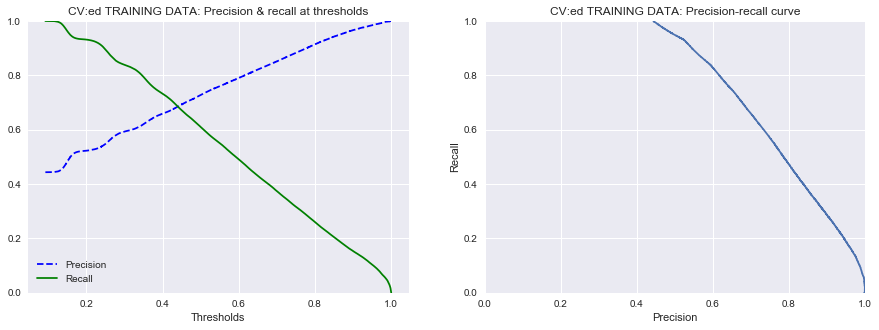

In [224]:
obtain_and_plot_evaluation_figures(model=rfc1, X=X_train_prep, y=y_train_clf, datatype='train', method='predict_proba', cv=3, verbose=0, title_prefix='CV:ed TRAINING DATA: ')

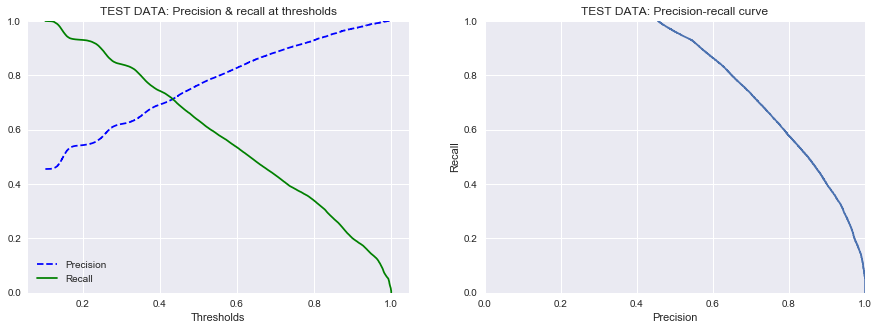

In [225]:
obtain_and_plot_evaluation_figures(model=rfc1, X=X_test_prep, y=y_test_clf, datatype='test', method='predict_proba', verbose=0, title_prefix='TEST DATA: ')

In [226]:
print('CV:ed TRAINING DATA: \n' + classification_report(y_train_clf, cross_val_predict(rfc1, X_train_prep, y_train_clf, cv=3)))
print('TEST DATA: \n' + classification_report(y_test_clf, rfc1.predict(X_test_prep)))

CV:ed TRAINING DATA: 
             precision    recall  f1-score   support

          0       0.83      0.89      0.86    849233
          1       0.73      0.61      0.66    404305

avg / total       0.80      0.80      0.80   1253538

TEST DATA: 
             precision    recall  f1-score   support

          0       0.84      0.91      0.87    168495
          1       0.76      0.63      0.69     79181

avg / total       0.82      0.82      0.82    247676



### Class balanced

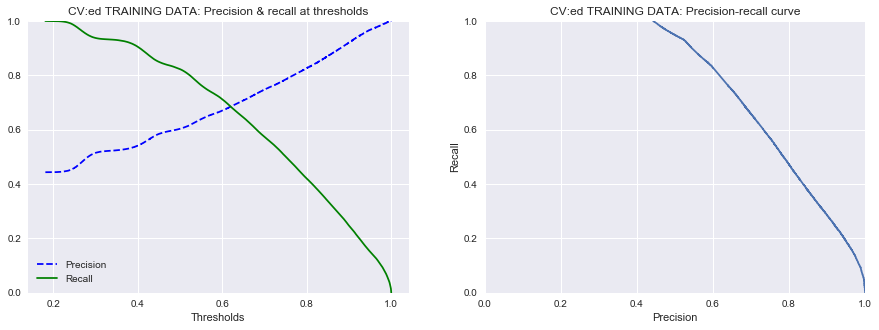

In [227]:
obtain_and_plot_evaluation_figures(model=rfc2, X=X_train_prep, y=y_train_clf, datatype='train', method='predict_proba', cv=3, verbose=0, title_prefix='CV:ed TRAINING DATA: ')

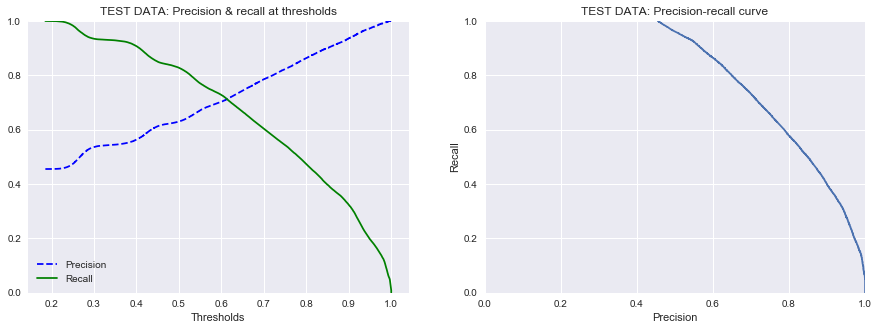

In [228]:
obtain_and_plot_evaluation_figures(model=rfc2, X=X_test_prep, y=y_test_clf, datatype='test', method='predict_proba', verbose=0, title_prefix='TEST DATA: ')

In [229]:
print('CV:ed TRAINING DATA: \n' + classification_report(y_train_clf, cross_val_predict(rfc2, X_train_prep, y_train_clf, cv=3)))
print('TEST DATA: \n' + classification_report(y_test_clf, rfc2.predict(X_test_prep)))

CV:ed TRAINING DATA: 
             precision    recall  f1-score   support

          0       0.90      0.74      0.81    849233
          1       0.60      0.82      0.70    404305

avg / total       0.80      0.77      0.78   1253538

TEST DATA: 
             precision    recall  f1-score   support

          0       0.91      0.77      0.83    168495
          1       0.63      0.83      0.72     79181

avg / total       0.82      0.79      0.80    247676



### Feature importance

In [230]:
attribute_names = list(num_mapper.transformed_names_) + list(cat_mapper.transformed_names_)
sorted(zip(rfc1.feature_importances_, attribute_names), reverse=True)

[(0.32398119299998684, 'alpha_crime_dens_pop_7'),
 (0.2624984446400793, 'alpha_crime_dens_area_7'),
 (0.09138807710600082, 'alpha_crime_dens_pop_30'),
 (0.08623645869604699, 'alpha_crime_dens_area_30'),
 (0.08445825574887343, 'Pop_cnt'),
 (0.04708681787233615, 'Area'),
 (0.021137187080349017, 'Crime_cat_LARCENY/THEFT'),
 (0.017668010369842748, 'median_age'),
 (0.014188181020606885, 'median_income'),
 (0.01350337251737748, 'Male_pop_ratio'),
 (0.013225855610009418, 'Age18Plus_ratio'),
 (0.01118522995695432, 'evictions_PkC'),
 (0.0027691402839760777, 'weekday_num'),
 (0.002555423675413299, 'Crime_cat_DRUG/NARCOTIC'),
 (0.00219411903693384, 'Crime_cat_VEHICLE THEFT'),
 (0.001728937467746466, 'Crime_cat_ROBBERY'),
 (0.0011215755088240795, 'Season'),
 (0.0010786644353779735, 'weekend'),
 (0.0007487590422235328, 'Crime_cat_ASSAULT'),
 (0.0007035223537514432, 'Crime_cat_BURGLARY'),
 (0.0005427745772896749, 'Crime_cat_VANDALISM')]

## Predictions

We output probabilities of crimes of different categories taking place given a neighborhood and a date. Due to the structure of some of the features, primarily the alpha-days features, historical and future dates are hendled separately. But it's also for performance reasons.

### Helper functions

In [232]:
def retrieve_imputed_assembled_feature_matrix(CDG_lookup, pdate):
    #nh_features
    nh_features = CDG_lookup.drop_duplicates('NH')[['Area', 'Pop_cnt', 'median_age', 'median_income','Male_pop_ratio', 'Age18Plus_ratio']]

    #alpha
    alpha_cols=[col for col in CDG_lookup if 'alpha' in col]
    alpha_features = CDG_lookup.drop_duplicates(['Date','NH','Crime_cat']).groupby(['NH','Crime_cat']).median()[alpha_cols]
    alpha_features = alpha_features.reset_index().drop('NH', axis=1)

    #evictions
    evictions_median = CDG_lookup.drop_duplicates(['NH','year']).median()['evictions_PkC']
    nh_year_features = pd.DataFrame(data=evictions_median, index=[0], columns={'evictions_PkC'})

    #date
    date_features = {}
    pdate = pd.to_datetime(pdate)
    date_features['weekday_num'] = pdate.weekday()
    date_features['weekend'] = np.asscalar(np.where(date_features['weekday_num'] >= 4, 1, 0))
    date_features['Season'] = (pdate - pd.DateOffset(months=1)).quarter
    date_features = pd.DataFrame(data=date_features, index=[0])

    #Crime cats
    crime_cats = pd.DataFrame(crime_data_grd.drop_duplicates('Crime_cat')['Crime_cat'])

    #Stitch together
    X_pred = nh_features.reset_index(drop=True).copy()
    X_pred = X_pred.merge(nh_year_features, left_index=True, right_index=True)
    X_pred = X_pred.merge(date_features, left_index=True, right_index=True)
    X_pred = X_pred.merge(crime_cats, how='right', left_index=True, right_index=True).fillna(method='ffill').fillna(method='bfill')
    X_pred = X_pred.merge(alpha_features, on='Crime_cat')
    X_pred = X_pred.reindex(sorted(X_pred.columns), axis=1)

    return X_pred

In [233]:
def get_crime_probas(NH, pdate, model=rfc1):
    #make sure we have a valid date
    try:
        pd.to_datetime(pdate)
    except:
        raise ValueError('pd.to_datetime() failed, only supports valid dates.')
    drop_columns=['Crime_count','Age18Plus_cnt', 'evictions','Date','NH','geometry','year']
    #Slice main table
    CDG_lookup = crime_data_grd.query('Date == @pdate and NH == @NH')
    #match in lookup table, construct X_pred easily
    if len(CDG_lookup) > 0:
        X_pred = CDG_lookup.drop(drop_columns, axis=1)
        X_pred_prep = full_pipeline.transform(X_pred)
        y_pred=model.predict_proba(X_pred_prep)
    #no match in table, impute date dependent historical features, and construct X_pred
    else:
        CDG_lookup = crime_data_grd.query('NH == @NH').drop('geometry', axis=1)
        #match on NH
        if len(CDG_lookup) > 0:
            X_pred = retrieve_imputed_assembled_feature_matrix(CDG_lookup, pdate)
            X_pred_prep = full_pipeline.transform(X_pred)
            y_pred=model.predict_proba(X_pred_prep)
        #No match on NH, throw error
        else:
            NHs = list(crime_data_grd.drop_duplicates('NH')['NH'])
            raise ValueError('Only supports (correctly spelled) SF neighborhoods: \n\n'+ str(NHs))
    #print neatly
    print(f'{NH} on {pdate}')
    for cat, pred in zip(X_pred['Crime_cat'],np.round(y_pred[:,1],2)):
        print(f'{cat:<20}{pred:<10}')
    return

### Get crime probabilities!

In [237]:
get_crime_probas('Mission', '2014-05-04')

Mission on 2014-05-04
ASSAULT             0.98      
BURGLARY            0.56      
DRUG/NARCOTIC       0.62      
LARCENY/THEFT       0.99      
ROBBERY             0.56      
VANDALISM           0.82      
VEHICLE THEFT       0.88      


## Future improvements

* More diverse data! Particularly dynamic data of people's movement and popularity of loctions, promoted by Rumi et al. (2018).
* Set up a smoother feature pipeline (for added flexibility and scalability)
* Include time of day of events to create features related to whether it's dark, should be a impactful feature
* Better account for trends in crime, ideally in a way that extrapolates outside of data scope to make good future predictions 
* Further analyze results from predictions to improve features and engineer new features
* Don't assume NH data is constant in time (e.g. population count)
* Consider over/undersampling, particularly if spatiotemporal resolution of prediction increases (thereby incresing imbalance)
* Apply weighted medians when aggregating some features from CT to NH level (although weighted average of medians > median of medians)
* Re-engineer some features, e.g. make derived date features, e.g. weekday, periodic (since the distance between Sunday and Monday is the same as Saturday and Sunday, which is currently not reflected in the feature). They could be made categorical, but that would dilute the data unnecessarily. 